# Training

## Intro

<img src="images/text.png">
<img src="images/recognition.png">
<img src="images/data.png">
<p>The model is trained using the <a href="https://www.robots.ox.ac.uk/~vgg/data/text/">MJSynth</a> dataset. This dataset consists of 9 million automatically generated images covering 90k English words.</p>

## Import dependencies

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt

from pathlib import Path

from tools import plot_images

import sys
sys.path.insert(0, "..")
import datasets
import vit

%matplotlib inline

## Load the dataset

To load dataset, you need to specify the path to it:

In [2]:
dataset_path = "/home/oleg/Documents/datasets/mjsynth"
train_ds, val_ds, test_ds = datasets.load_mjsynth(dataset_path)

A hash table to map numeric labels to characters:

In [4]:
labels = tf.range(len(datasets.CHARS))
label_to_char = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(labels, datasets.CHARS), "")

Let's plot some images from the dataset. Note, that all images were resized to 32x100 pixels.

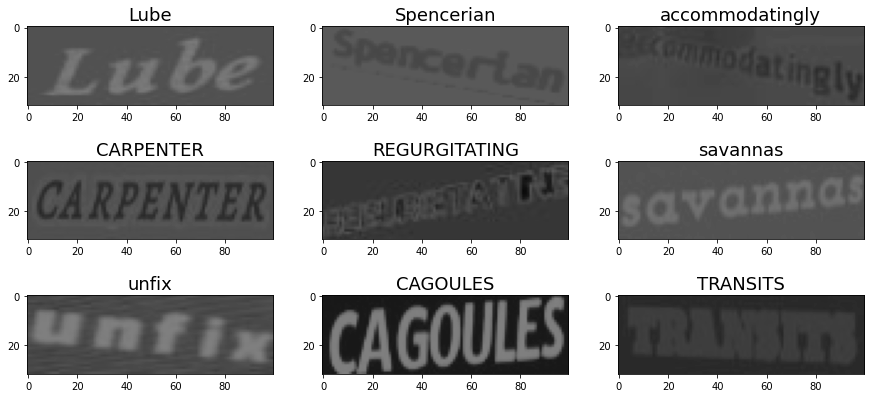

In [5]:
images = [(image.numpy() + 1) / 2 for image, _ in train_ds.take(9)]
texts = ["".join(c.decode("UTF-8") for c in label_to_char.lookup(text_labels).numpy())
         for _, text_labels in train_ds.take(9)]
    
plt.figure(figsize=(15, 7))
plot_images(images, texts, rows=3, columns=3)

Shuffle, batch and prefetch the dataset:

In [6]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 512
LABELS_PADDING_CONST = -1

def configure_for_performance(dataset, shuffle=False, seed=None):
    if shuffle:
      dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE, seed=seed)
    
    dataset = dataset.padded_batch(
        BATCH_SIZE,
        padding_values=(None, LABELS_PADDING_CONST),
        padded_shapes=(
            [datasets.IMAGE_HEIGHT, datasets.IMAGE_WIDTH, datasets.IMAGE_CHANNELS],
            [None],)
        )
    
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

train_ds = configure_for_performance(train_ds, shuffle=True, seed=42)
val_ds = configure_for_performance(val_ds) 
test_ds = configure_for_performance(test_ds) 

## Train the model

<img src="images/model.png">
<p>The model is very similar to the one from the original <a href="https://arxiv.org/abs/2010.11929#:~:text=An%20Image%20is%20Worth%2016x16%20Words%3A%20Transformers%20for%20Image%20Recognition%20at%20Scale,-Alexey%20Dosovitskiy%2C%20Lucas&text=While%20the%20Transformer%20architecture%20has,to%20computer%20vision%20remain%20limited.">Vision Tranformer paper</a>. The input image is divided into patches, which are linearly projected (i.e. passed through a dense layer with linear activation function). Resulting vectors are summed up with positional encoding vectors and passed to a Transformer encoder. However, there are some changes that were made to use the model for Scene Text Recognition.</p>
<p>The input image is splitted only horizontally, so that each patch consist of 4 full columns of the original image (note that the scheme above uses wider patches for simplicity). This was inspired by the <a href="https://arxiv.org/abs/1507.05717">CRNN paper</a>, where recurrent layers on each timestep receive a horizontal patch of width 4 of the input image, that was passed through convolutional layers. Since patching is strictly horizontal, there is no need for the model to learn 2D relations between patches via a learnable positional encoding, so a static positional encoding based on sine and cosine functions of different frequencies is used as described in the <a href="https://arxiv.org/abs/1706.03762">Transformer paper</a>.</p>
<p>In the Scene Text Recognition, the model needs to recognize multiple characters instead of predicting just a single class label, so outputs of all positions of the Transformer encoder are passed to a dense layer with softmax activation function that produces a sequence of labels, which are passed to a <a href="https://www.cs.toronto.edu/~graves/icml_2006.pdf">Connectionist Temporal Classification (CTC)</a> loss (or decoder, if model is used for inference).</p>
<p>Tranformer encoder hyperparameters:
<ul>
    <li><i>num_encoders</i> = 5</li>
    <li<i>d<sub>model</sub> = 512</i></li>
    <li><i>d<sub>ff</sub> = 2048</i></li>
    <li><i>num_heads</i> = 8</li>
</ul></p>
<p>Dropout is applied to the output of each Transformer encoder sub-layer, before it is added to the sub-layer input and normalized. Dropout is also applied to the sums of the patches' projections and the positional encodings. This approach is similar to the  <a href="https://arxiv.org/abs/1706.03762">Transformer paper</a>. Dropout rate is equal to 0.1.</p>

In [7]:
PATCH_WIDTH = 4

NUM_ENCODERS = 5
D_MODEL = 512
D_FF = 2048
NUM_HEADS = 8

DROPOUT = 0.1

model = tf.keras.Sequential([
    vit.layers.HorizontalPatching(PATCH_WIDTH, datasets.IMAGE_HEIGHT, datasets.IMAGE_CHANNELS),
    tf.keras.layers.Dense(D_MODEL),
    vit.layers.PositionalEncoding(),
    tf.keras.layers.Dropout(DROPOUT),
    vit.layers.TransformerEncoder(NUM_ENCODERS, D_MODEL, NUM_HEADS, D_FF, dropout=DROPOUT),
    tf.keras.layers.Dense(len(datasets.CHARS) + 1, activation="softmax")
])

<p>Training is performed for 6 epoch using the <a href="https://arxiv.org/abs/1711.05101">AdamW optimizer</a>. Learning and weight decay rates are changing during the training according to a cosine decay strategy with a warmup. However, it looks like that dropout is enough for reducing variance and weight decay doesn't give any significant benefits, so its rate is currently set to always be equal to 0. Plots below show how both these rates change during the training.</p>

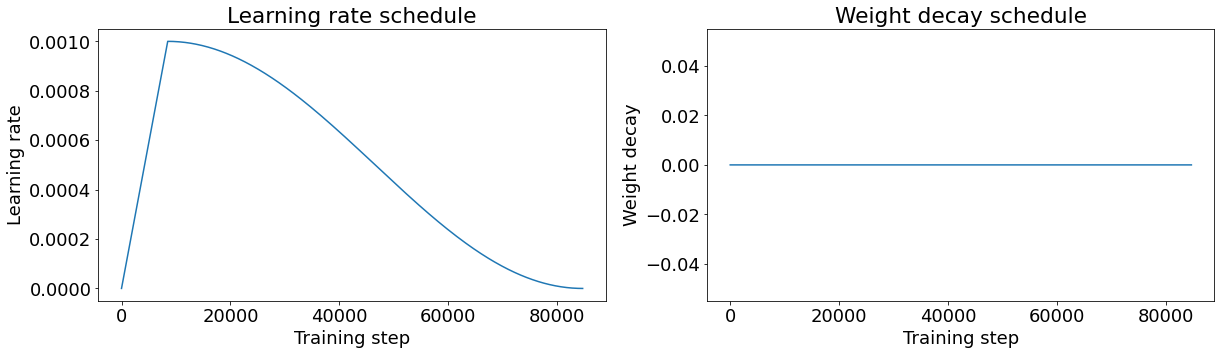

In [8]:
TRAIN_SIZE = 7224586
EPOCHS = 6

TOTAL_STEPS = TRAIN_SIZE * EPOCHS // BATCH_SIZE
WARMUP_FRACTION = 0.1

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0

lr_schedule = vit.schedules.CosineWarmupDecay(
    LEARNING_RATE, TOTAL_STEPS, WARMUP_FRACTION)

wd_schedule = vit.schedules.CosineWarmupDecay(
    WEIGHT_DECAY, TOTAL_STEPS, WARMUP_FRACTION)

plt.figure(figsize=(20, 5))
plt.rcParams["font.size"] = 18

plt.subplot(121)
plt.title("Learning rate schedule")
plt.plot(lr_schedule(tf.range(TOTAL_STEPS)))
plt.ylabel("Learning rate")
plt.xlabel("Training step")

plt.subplot(122)
plt.title("Weight decay schedule")
plt.plot(wd_schedule(tf.range(TOTAL_STEPS)))
plt.ylabel("Weight decay")
plt.xlabel("Training step")

optimizer = tfa.optimizers.AdamW(learning_rate=lr_schedule,
                                 weight_decay=wd_schedule)

<p>ModelCheckpoint callback is used to save weights each 50 batches if the loss has improved:</p>

In [9]:
SAVED_WEIGHTS = Path("saved_weights") / "mjsynth.h5"
SAVE_FREQUENCY = 50

SAVED_WEIGHTS.parent.mkdir(parents=True, exist_ok=True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    SAVED_WEIGHTS, monitor="loss", save_best_only=True,
    save_weights_only=True, save_freq=SAVE_FREQUENCY)

<p>Special CTC loss and accuracy are used for the model:</p>

In [10]:
model.compile(
    optimizer=optimizer, 
    loss=vit.losses.CTCLoss(true_labels_padding_value=LABELS_PADDING_CONST),
    metrics=[vit.metrics.CTCAccuracy(true_labels_padding_value=LABELS_PADDING_CONST)]
)

<p>Fit the model:</p>

In [13]:
model.fit(train_ds, epochs=EPOCHS, callbacks=[model_checkpoint])

Epoch 1/6
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
14111/14111 [==============================] - 5216s 370ms/step - loss: 9.4654 - accuracy: 0.4584
Epoch 2/6
14111/14111 [==============================] - 4649s 329ms/step - loss: 2.4809 - accuracy: 0.7541
Epoch 3/6
14111/14111 [==============================] - 4639s 329ms/step - loss: 1.8877 - accuracy: 0.8060
Epoch 4/6
14111/14111 [==============================] - 4645s 329ms/step - loss: 1.5089 - accuracy: 0.8412
Epoch 5/6
14111/14111 [==============================] - 4645s 329ms/step - loss: 1.2187 - accuracy: 0.8691
Epoch 6/6
14111/14111 [==============================] - 4628s 328ms/step - loss: 1.0461 - accuracy: 0.8858


<p>Load the saved weights:</p>

In [16]:
model.load_weights(SAVED_WEIGHTS)

<p>Evaluate the model on the validation set:</p>

In [18]:
model.evaluate(val_ds)

1568/1568 [==============================] - 255s 162ms/step - loss: 1.0325 - accuracy: 0.8975


[1.0325475931167603, 0.8975223302841187]

<p>Save the whole model to use later for testing:</p>

In [19]:
model.compile()
model.save("saved_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/assets
